In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import optuna
from optuna.visualization import plot_optimization_history
from optuna.samplers import RandomSampler

## Чтение данных

In [2]:
df = pd.read_csv("train.csv")
pd.set_option('display.max_rows', None, 'display.max_columns', None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73995 entries, 0 to 73994
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         73995 non-null  uint64 
 1   org_id                          73995 non-null  uint64 
 2   rating                          73995 non-null  float64
 3   ts                              73995 non-null  int64  
 4   user_city                       73995 non-null  object 
 5   org_city                        73995 non-null  object 
 6   average_bill                    45433 non-null  float64
 7   rating_org                      73995 non-null  float64
 8   rubrics                         73995 non-null  object 
 9   food_delivery                   73995 non-null  int64  
 10  breakfast                       73995 non-null  int64  
 11  takeaway                        73995 non-null  int64  
 12  summer_terrace                  

In [3]:
df.describe()

,user_id,org_id,rating,ts,average_bill,rating_org,food_delivery,breakfast,takeaway,summer_terrace,wi_fi,business_lunch,payment_by_credit_card,coffee_to_go,closed_for_quarantine,online_takeaway,karaoke,special_menu,sports_broadcasts,food_court1,craft_beer,projector,gift_certificate,wheelchair_access,automatic_door,food_product_delivery,car_park,parking_disabled,toilet_for_disabled,promotions,cafe,minimum_order,free_delivery,self_service_kiosks,has_restaurant,air_conditioning,pets,elevator,has_bar,internet access,privilege_tickets,organic_food,vip_zone,hall_capacity,face_control,show_program,music,chillout,dancefloor,dress_code,billiards,strip,elevator_wheelchair_accessible,ramp,around_the_clock_work1,pickup,farm_products,delivery,coffee_shop,call_button,wheelchair_accessible,table_games,vinotheque,cakes_for_different_occasions,accepted_credit_cards,kalyan,teahouse,bread_from_tandoor,handmade_goods
count,7.399500e+04,7.399500e+04,73995.000000,73995.000000,45433.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000,73995.000000
mean,9.196627e+18,9.038261e+18,4.322779,714.540766,1075.891973,4.319332,0.757119,0.576607,0.649206,0.602554,0.860518,0.618555,0.901764,0.663707,0.424623,0.339009,0.376809,0.413609,0.319386,0.122819,0.192229,0.187688,0.104521,0.498385,0.131171,0.102291,0.131144,0.122143,0.126765,0.059166,0.082222,0.025407,0.053355,0.070532,0.018096,0.004271,0.003987,0.004230,0.003689,0.004244,0.009609,0.028461,0.010528,0.010460,0.012433,0.012920,0.014933,0.009609,0.015582,0.014393,0.017704,0.011285,0.011393,0.007784,0.020799,0.028002,0.024056,0.018853,0.001230,0.008014,0.007406,0.017677,0.002149,0.002419,0.001027,0.000932,0.001230,0.002960,0.001216
std,5.312861e+18,5.275833e+18,1.130370,293.492213,2733.507688,0.308584,0.428827,0.494100,0.477222,0.489373,0.346452,0.485745,0.297636,0.472444,0.494289,0.473376,0.484590,0.492483,0.466242,0.328232,0.394055,0.390466,0.305937,0.500001,0.337590,0.303032,0.337560,0.327454,0.332712,0.235937,0.274704,0.157359,0.224742,0.256043,0.133299,0.065210,0.063015,0.064901,0.060629,0.065004,0.097553,0.166288,0.102064,0.101739,0.110810,0.112929,0.121287,0.097553,0.123853,0.119105,0.131874,0.105628,0.106127,0.087885,0.142711,0.164979,0.153223,0.136005,0.035047,0.089162,0.085739,0.131775,0.046306,0.049125,0.032032,0.030523,0.035047,0.054323,0.034854
min,1.445171e+14,1.626686e+15,1.000000,0.000000,500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.614445e+18,4.504716e+18,4.000000,505.000000,500.000000,4.180952,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [4]:
y = df['rating_org']

In [5]:
def print_corr(c):
    plt.figure(figsize=(20, 20))
    sns.heatmap(c, cmap='coolwarm')
    plt.show()

## Просмотр корреляции между параметрами

In [6]:
def norm(data):
    scaler = preprocessing.MinMaxScaler()

    names = data.columns
    d = scaler.fit_transform(data)

    scaled_df = pd.DataFrame(d, columns=names)
    return scaled_df

In [7]:
df = df.join(pd.get_dummies(df['rubrics']))
df = df.join(pd.get_dummies(df['user_city'], prefix='user_'))
df = df.join(pd.get_dummies(df['org_city'], prefix='org_'))
df = df.drop(columns=['average_bill', 'rubrics', 'user_city', 'org_city'])
df = norm(df)


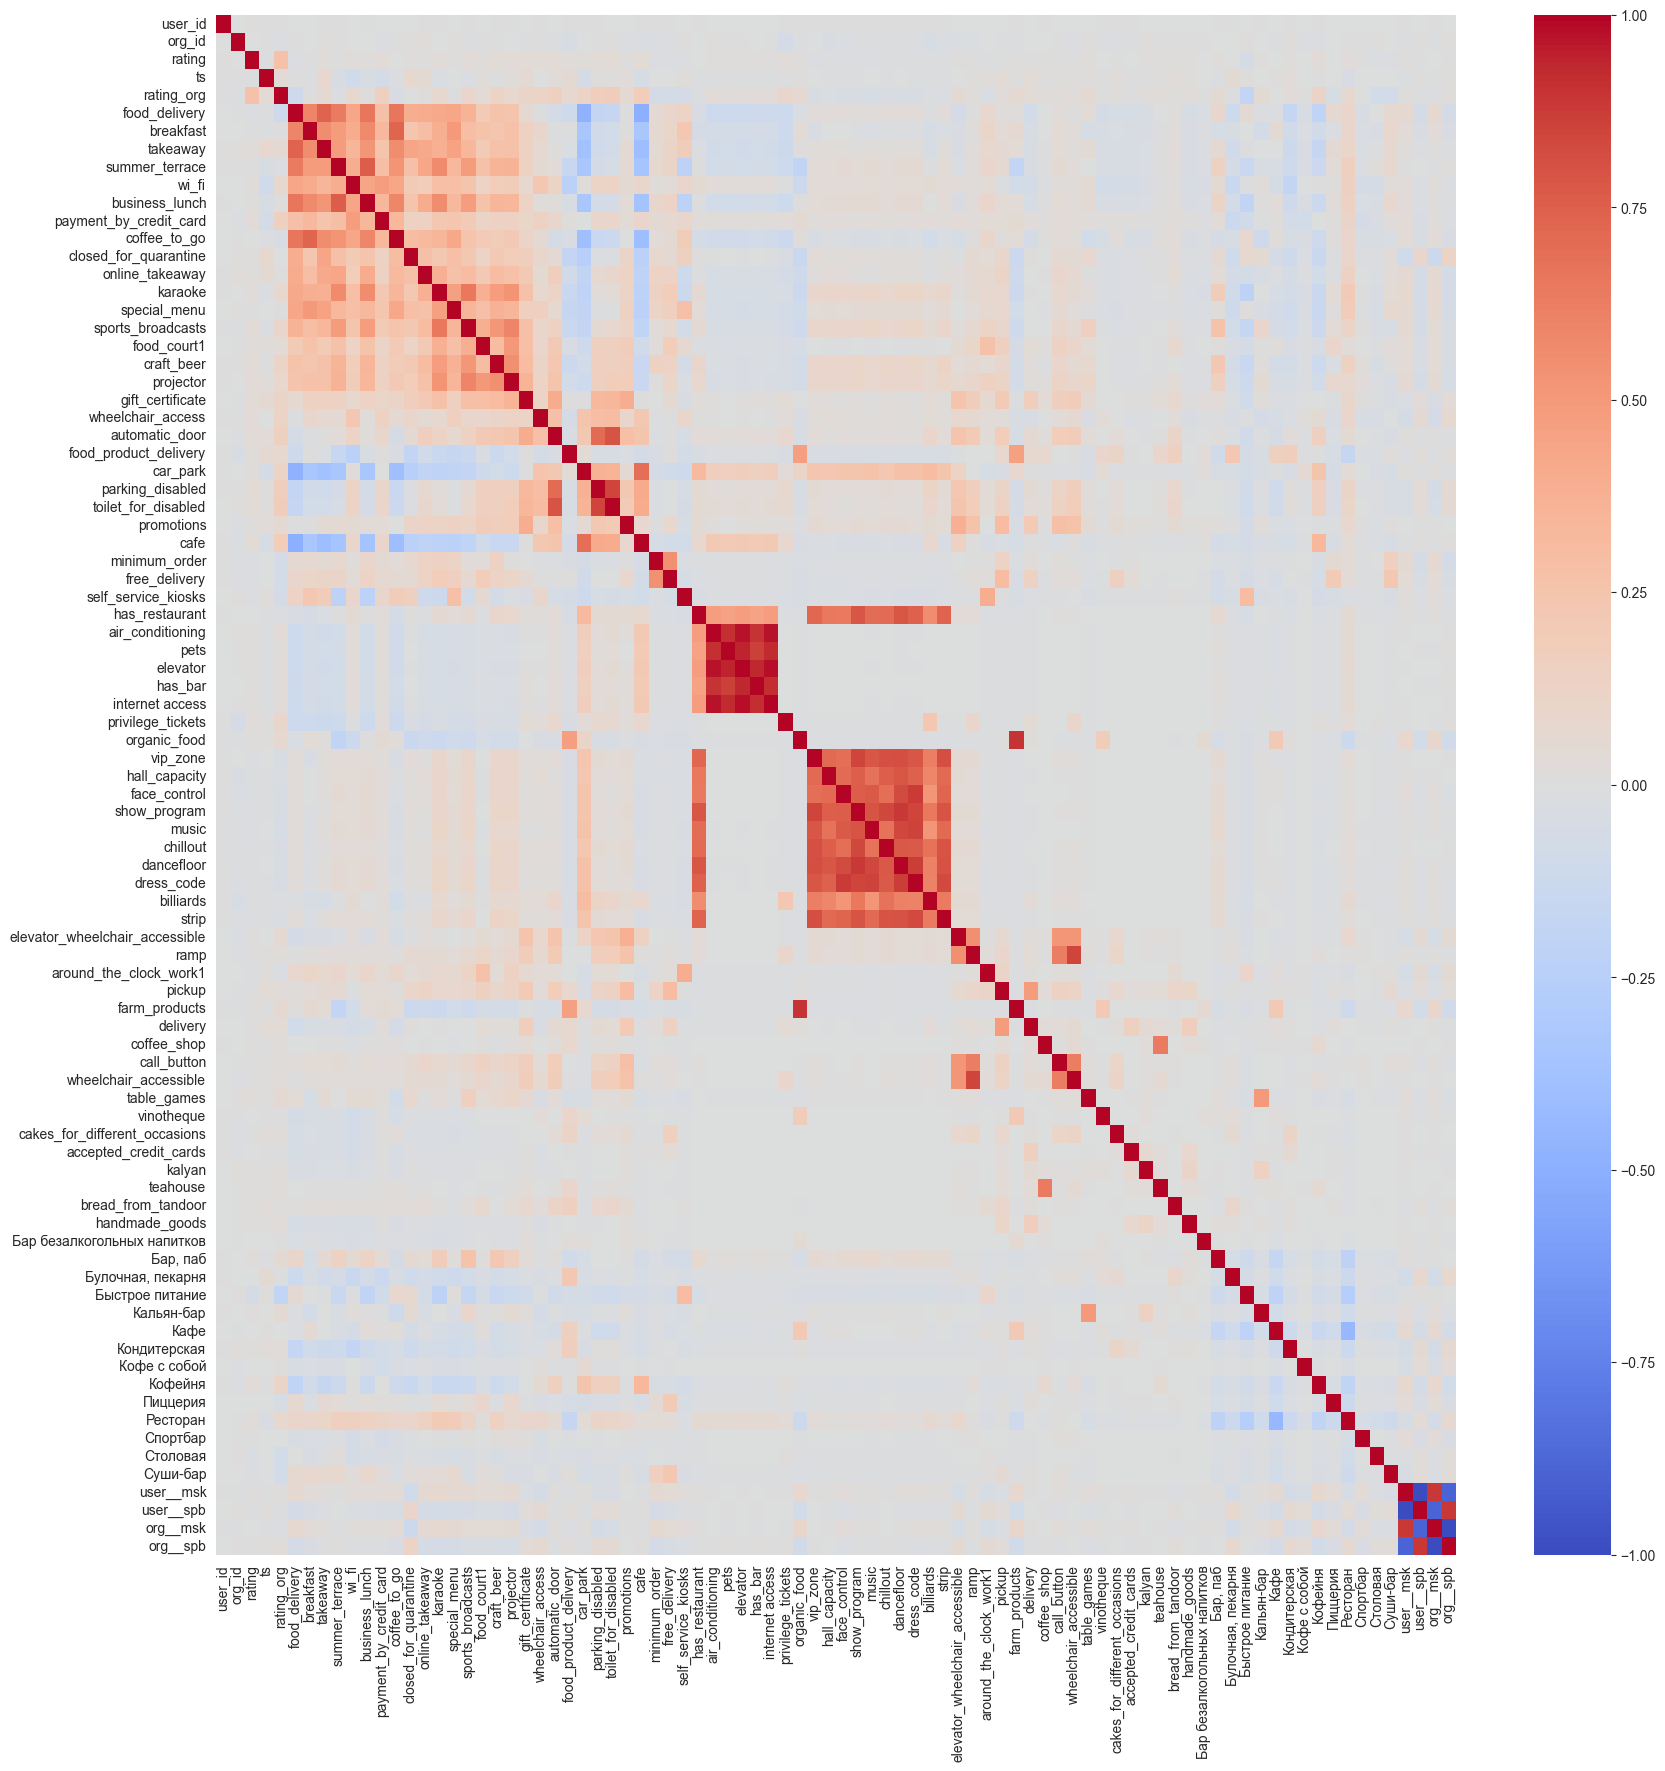

In [8]:
correlation = df.corr()
print_corr(correlation)

## Вывод параметров, с корреляцией > 0.5

In [9]:
def most_corr(data):
    for column in data.columns:
        x = correlation[correlation[column].between(0.5, 1, inclusive="neither")].index
        if len(x) > 0:
            print(column, ', '.join(x), sep=', ')

In [10]:
# most_corr(correlation)

## Сгруппированные столбцы

In [11]:
corr_data = {
    # "cafe": 'business_lunch, food_delivery, breakfast, takeaway, summer_terrace, coffee_to_go',
    "bar": 'projector, karaoke, sports_broadcasts, food_court1, craft_beer',
    "disability": 'automatic_door, parking_disabled, toilet_for_disabled',
    "visit": "car_park, cafe",
    # "pay" : 'minimum_order, free_delivery',
    # "comfort": 'air_conditioning, pets, elevator, has_bar, internet access',
    # "restaurant": 'vip_zone, has_restaurant, hall_capacity, face_control, show_program, music, chillout, dancefloor, dress_code, billiards, strip',
    # 'disability2': 'elevator_wheelchair_accessible, ramp, call_button, wheelchair_accessible',
    # 'good_food' : 'organic_food, farm_products',
    # 'coffee': 'coffee_shop, teahouse'
}

In [12]:
def get_new_df(data):
    new_df = pd.DataFrame()
    for i in corr_data:
        new_df[i] = data[corr_data[i].split(', ')].max(axis=1)
        # new_df[i] = data[corr_data[i].split(', ')].mean(axis=1)
    return new_df

In [13]:
X = get_new_df(df)

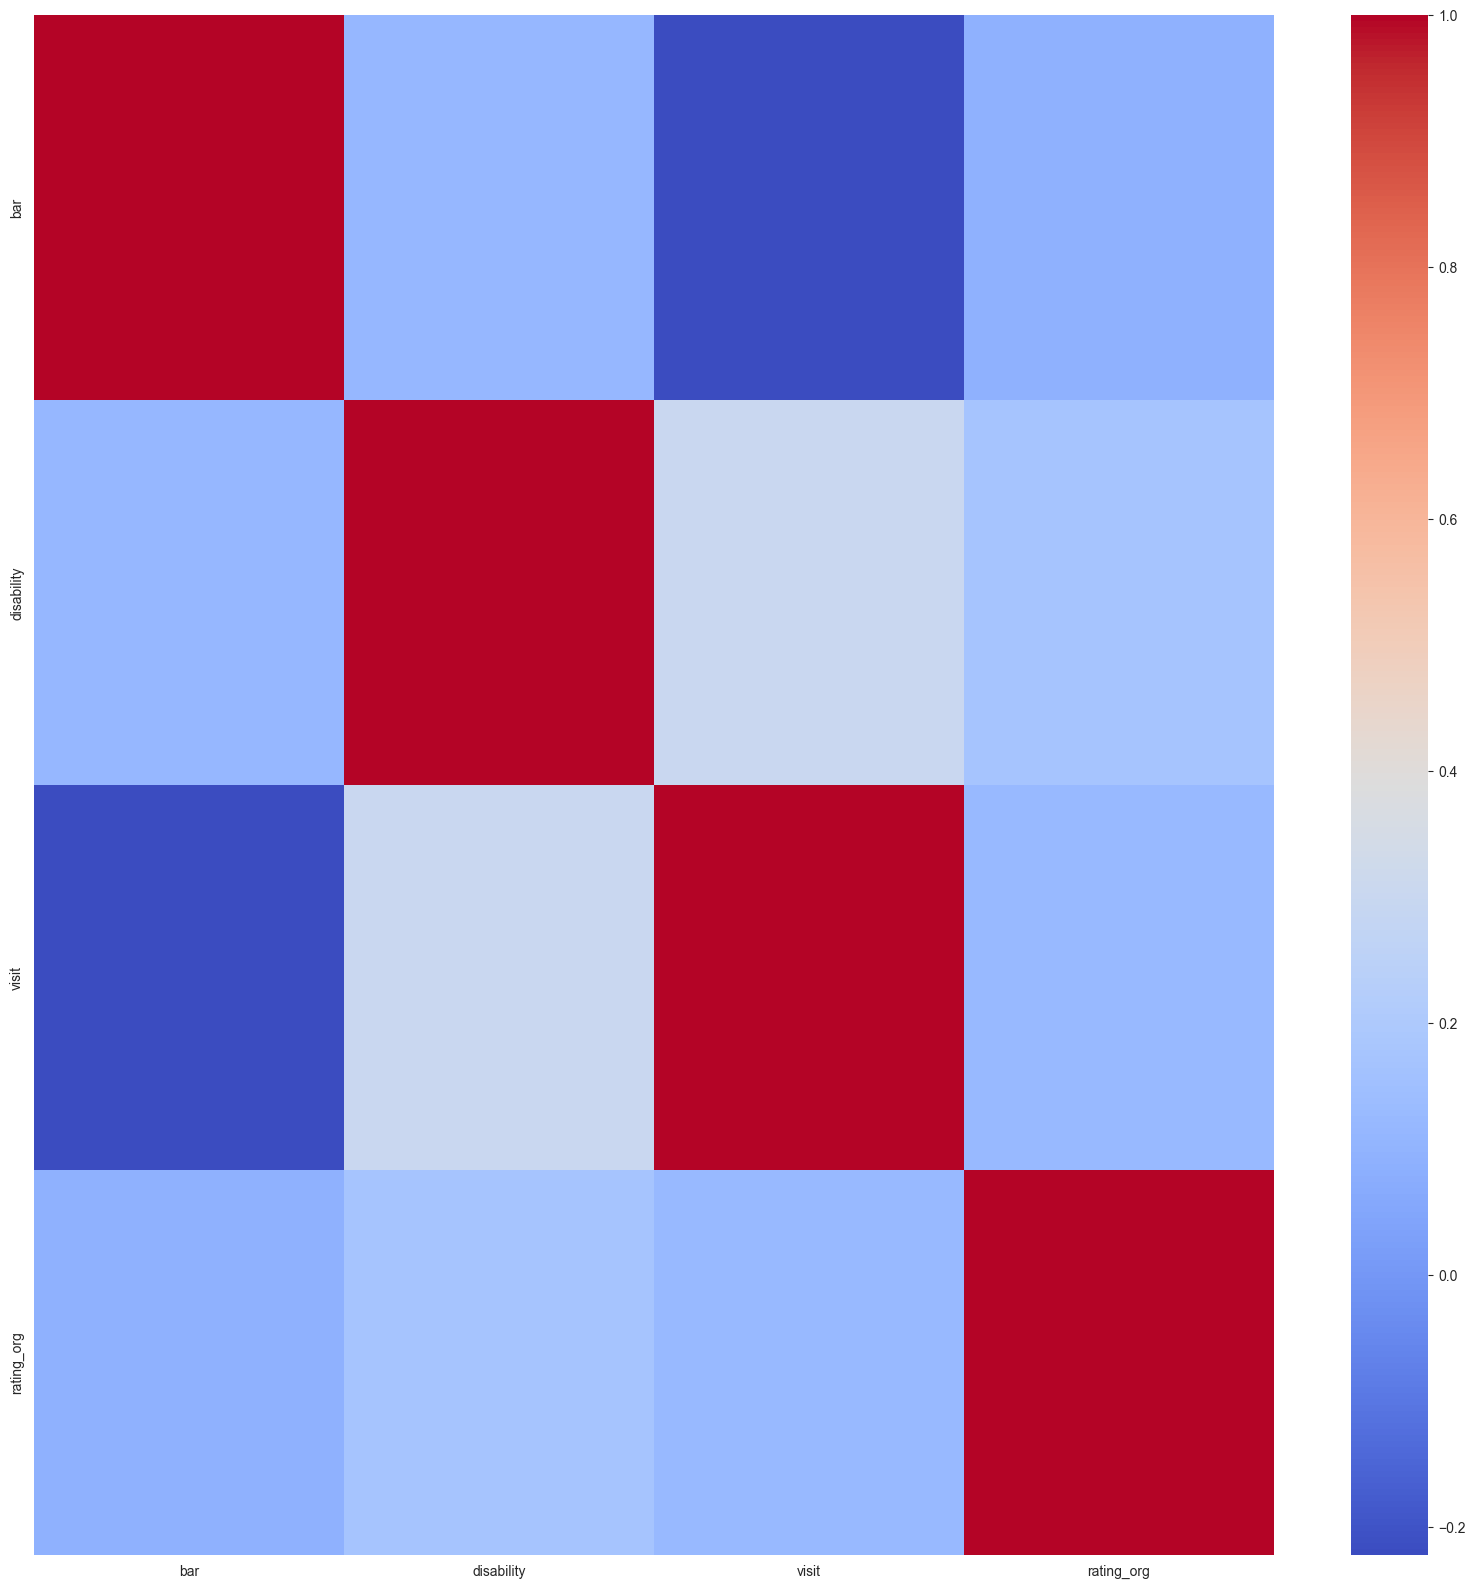

In [14]:
new_c = X.join(y).corr()
print_corr(new_c)

## Обучение модели на тренировочных данных

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [16]:
def objective(trial):
    # Определение гиперпараметров
    algorithm = trial.suggest_categorical('algorithm',
                                          ['KNeighborsRegressor', 'SVR', 'RandomForestRegressor', 'BayesianRidge'])
    params = {
        'KNeighborsRegressor': {
            'n_neighbors': trial.suggest_int('n_neighbors', 1, 2000),
            'leaf_size': trial.suggest_int('leaf_size', 1, 512),
            'p': trial.suggest_int('p', 1, 2)
        },
        'SVR': {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'C': trial.suggest_float('C', 1e-1, 1e3),
            'epsilon': trial.suggest_float('epsilon', 1e-2, 1),
            'gamma': trial.suggest_float('gamma', 1e-1, 1e1)
        },
        'RandomForestRegressor': {
            'criterion': trial.suggest_categorical('criterion',
                                                   ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        },
        'BayesianRidge': {
            'n_iter': trial.suggest_int('n_iter', 100, 300),
            'alpha_1': trial.suggest_float('alpha_1', 1e-8, 1, log=True),
            'alpha_2': trial.suggest_float('alpha_2', 1e-8, 1, log=True),
            'lambda_1': trial.suggest_float('lambda_1', 1e-8, 1, log=True),
            'lambda_2': trial.suggest_float('lambda_2', 1e-8, 1, log=True),
        }
    }

    # Создание модели
    model = globals()[algorithm](**params[algorithm])
    model.fit(X_train, y_train)
    # score = cross_val_score(model, X, y, n_jobs=-1, cv=2, scoring='neg_mean_absolute_percentage_error').mean()
    y_predicted = model.predict(X_val)
    score = mean_absolute_percentage_error(y_val, y_predicted)
    # Минимизация отрицательного среднеквадратичного отклонения
    return score

In [17]:
# Создание объекта study и запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=-1, timeout=600)

# Вывод результатов
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2023-04-20 16:58:49,255] A new study created in memory with name: no-name-f0240b8f-985e-4a98-a84d-81b6c4b0b8be
[I 2023-04-20 16:59:07,225] Trial 0 finished with value: 0.05266275414330601 and parameters: {'algorithm': 'KNeighborsRegressor', 'n_neighbors': 505, 'leaf_size': 425, 'p': 2, 'kernel': 'rbf', 'C': 54.38033233329625, 'epsilon': 0.5333758274074557, 'gamma': 5.884658389626077, 'criterion': 'friedman_mse', 'n_estimators': 958, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 10, 'n_iter': 156, 'alpha_1': 0.0023766253266863067, 'alpha_2': 2.6428854036362545e-06, 'lambda_1': 1.2921684045446595e-08, 'lambda_2': 0.3311933789974341}. Best is trial 0 with value: 0.05266275414330601.
[I 2023-04-20 16:59:07,242] Trial 3 finished with value: 0.05267974238173749 and parameters: {'algorithm': 'KNeighborsRegressor', 'n_neighbors': 470, 'leaf_size': 98, 'p': 2, 'kernel': 'linear', 'C': 115.3954436971379, 'epsilon': 0.5957498884067626, 'gamma': 0.2689013954704103, 'criterion': '

Number of finished trials: 50
Best trial: {'algorithm': 'KNeighborsRegressor', 'n_neighbors': 1727, 'leaf_size': 469, 'p': 2, 'kernel': 'linear', 'C': 560.7311876488176, 'epsilon': 0.7411344750891959, 'gamma': 8.49775734221064, 'criterion': 'poisson', 'n_estimators': 305, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'n_iter': 298, 'alpha_1': 0.0002207508964418829, 'alpha_2': 4.60928093541685e-05, 'lambda_1': 1.0086207823424713e-08, 'lambda_2': 0.1639785071123842}
Best score: 0.0523129758689986


In [26]:
plot_optimization_history(study).show()

In [27]:
# Получаем информацию о важности каждого гиперпараметра
importance = optuna.importance.get_param_importances(study)
# Выводим информацию о полезности гиперпараметров
for param, importance in importance.items():
    print(f'{param}: {importance}')

algorithm: 0.34420508856108356
C: 0.18323640148521567
kernel: 0.12220358979629263
min_samples_split: 0.08102717511526396
epsilon: 0.07939004860937478
lambda_1: 0.04171720047849653
n_iter: 0.032487726976533786
lambda_2: 0.026454676730223343
max_depth: 0.022633201467555264
leaf_size: 0.017125977303096285
criterion: 0.01694562911470524
gamma: 0.016670140407739294
n_estimators: 0.008891847858799035
alpha_1: 0.003958880038339769
n_neighbors: 0.002234774420644656
min_samples_leaf: 0.0007412216375975188
p: 7.480636390806623e-05
alpha_2: 1.6136351305435765e-06


In [28]:
# todo: need fix params
algorithm = study.best_trial.params['algorithm']
param = study.best_trial.params
print(param)
neigh = SVR(kernel=param['kernel'],
            C=param['C'],
            epsilon=param['epsilon'],
            gamma=param['gamma'])
neigh.fit(X_train, y_train)

{'algorithm': 'KNeighborsRegressor', 'n_neighbors': 1727, 'leaf_size': 469, 'p': 2, 'kernel': 'linear', 'C': 560.7311876488176, 'epsilon': 0.7411344750891959, 'gamma': 8.49775734221064, 'criterion': 'poisson', 'n_estimators': 305, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 8, 'n_iter': 298, 'alpha_1': 0.0002207508964418829, 'alpha_2': 4.60928093541685e-05, 'lambda_1': 1.0086207823424713e-08, 'lambda_2': 0.1639785071123842}


SVR(C=560.7311876488176, epsilon=0.7411344750891959, gamma=8.49775734221064,
    kernel='linear')

In [18]:
study_random = optuna.create_study(direction='minimize', sampler=RandomSampler())
study_random.optimize(objective, n_trials=50, n_jobs=-1, timeout=600)

[I 2023-04-20 17:28:57,788] A new study created in memory with name: no-name-b039b56b-d6f4-4441-a334-8524352b035a
[I 2023-04-20 17:28:58,406] Trial 6 finished with value: 0.05291560945873902 and parameters: {'algorithm': 'BayesianRidge', 'n_neighbors': 213, 'leaf_size': 192, 'p': 1, 'kernel': 'linear', 'C': 247.66103038996974, 'epsilon': 0.4233524322497687, 'gamma': 4.468538766716482, 'criterion': 'absolute_error', 'n_estimators': 309, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 7, 'n_iter': 121, 'alpha_1': 5.323730315830402e-08, 'alpha_2': 6.707104936087508e-06, 'lambda_1': 0.0016156321261309083, 'lambda_2': 0.011390197876909263}. Best is trial 6 with value: 0.05291560945873902.
[I 2023-04-20 17:29:14,318] Trial 2 finished with value: 0.052837537500822165 and parameters: {'algorithm': 'KNeighborsRegressor', 'n_neighbors': 245, 'leaf_size': 175, 'p': 2, 'kernel': 'rbf', 'C': 632.1250570157056, 'epsilon': 0.44633792933401895, 'gamma': 3.678827130121683, 'criterion': 'po

KeyboardInterrupt: 

In [ ]:
plot_optimization_history(study_random).show()

In [ ]:
# todo: need fix params
algorithm_random = study_random.best_trial.params['algorithm']
param = study_random.best_trial.params
print(param)
neigh_random = SVR(kernel=param['kernel'],
            C=param['C'],
            epsilon=param['epsilon'],
            gamma=param['gamma'])
neigh_random.fit(X_train, y_train)

In [49]:
y_predicted_random = neigh_random.predict(X_test)
mean_absolute_percentage_error(y_test, y_predicted_random)

## Обучение на всех данных, для итогового предсказания

In [ ]:
neigh.fit(X, y)

In [ ]:
test = pd.read_csv("test_x.csv")
new_test = get_new_df(test)
y_test = neigh.predict(new_test)

In [ ]:
d = {'id': new_test.index, 'rating_org': y_test}
y_df = pd.DataFrame(data=d)
y_df.to_csv('prediction.csv', index=False)

In [ ]:
y_df.sample(10)